In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("../science.mplstyle")

from sklearn.utils import shuffle


import os

import pickle

from helpers.data_transforms import inverse_transform, clean_data
from helpers.BDT import *
from helpers.physics_functions import *
from helpers.plotting import hist_all_features_array

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
# selecting appropriate device
CUDA = torch.cuda.is_available()
print("cuda available:", CUDA)
device = torch.device("cuda" if CUDA else "cpu")


cuda available: True


In [3]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file)
    
    
config_id = "CATHODE_8"

configs_path = f"configs/{config_id}.yml"
with open(configs_path, "r") as file:
    flow_configs = yaml.safe_load(file)
    


In [33]:
# load in the data

bands = ["SBL", "SR", "SBH"]
data_dict = {}

working_dir = "/global/cfs/cdirs/m3246/rmastand/dimuonAD/projects/logit_08_22/"
#\working_dir = "/global/u1/r/rmastand/dimuonAD/projects/powerscaler_0813/"


flow_id = "double_1"
particle_type = "upsilon"
project_id = f"lowmass_{particle_type}_nojet"


flow_training_dir = os.path.join(f"{working_dir}/models", f"{project_id}/{flow_id}/{config_id}")
#

with open(f"{flow_training_dir}/flow_samples", "rb") as infile: 
    data_dict = pickle.load(infile)
    
with open(f"{working_dir}/processed_data/{project_id}_test_band_data", "rb") as infile: 
    test_dict = pickle.load(infile)
    
with open(f"{working_dir}/processed_data/{project_id}_samesign_band_data", "rb") as infile: 
    samesign_dict = pickle.load(infile)
    
    
"""
    
    
with open(f"{flow_training_dir}/flow_samples", "rb") as infile: 
    data_dict = pickle.load(infile)
    
with open(f"{working_dir}/processed_data/{project_id}_test_band_data", "rb") as infile: 
    samesign_dict = pickle.load(infile)
    
with open(f"{working_dir}/processed_data/{project_id}_samesign_band_data", "rb") as infile: 
    test_dict = pickle.load(infile)
"""

with open(f"{flow_training_dir}/configs.txt", "rb") as infile: 
    configs = infile.readlines()[0].decode("utf-8")
    print(configs)



feature_set = ['dimu_pt', 'dimu_eta', 'dimu_mass']



In [36]:
# Assemble the test set -- consists of both SB and SR

feature_set = ['dimu_pt', 'dimu_eta', 'dimu_mass']


# test set events: not used during flow training
num_events_test_SR = test_dict["SR"]["s_inj_data"]["dimu_mass"].shape[0]
test_events_SB = np.empty((num_events_test_SB, len(feature_set)))
num_events_test_SB = test_dict["SBH"]["s_inj_data"]["dimu_mass"].shape[0]+test_dict["SBL"]["s_inj_data"]["dimu_mass"].shape[0]
test_events_SR = np.empty((num_events_test_SR, len(feature_set)))



# samesign events:
num_events_samesign = samesign_dict["SR"]["s_inj_data"]["dimu_mass"].shape[0]+samesign_dict["SBH"]["s_inj_data"]["dimu_mass"].shape[0]+samesign_dict["SBL"]["s_inj_data"]["dimu_mass"].shape[0]
test_events_samesign = np.empty((num_events_samesign, len(feature_set)))





for i, feat in enumerate(feature_set):
    
    test_events_SR[:,i] = test_dict["SR"]["s_inj_data"][feat].reshape(-1,)
    loc_arr = np.concatenate((test_dict["SBL"]["s_inj_data"][feat], test_dict["SBH"]["s_inj_data"][feat]))
    test_events_SB[:,i] = loc_arr.reshape(-1,)

    
    loc_arr = np.concatenate((samesign_dict["SR"]["s_inj_data"][feat], samesign_dict["SBL"]["s_inj_data"][feat], samesign_dict["SBH"]["s_inj_data"][feat]))
    test_events_samesign[:,i] = loc_arr.reshape(-1,)


print(data_dict["SR"].shape)
    
print(f"Total number of test events: {test_events_SR.shape[0]+test_events_SB.shape[0]}. {test_events_SR.shape[0]} in SR, {test_events_SB.shape[0]} in SB.")


SR_min_rescaled = np.min(test_events_SR[:,-1])
SR_max_rescaled = np.max(test_events_SR[:,-1])


# ROC events: SB seen during flow training. Just meant to be a high-stats sample for the roc curve
test_events_ROC = np.vstack([data_dict["SR"],data_dict["SBH"],data_dict["SBL"]  ])

(97583, 3)
Total number of test events: 34998. 9605 in SR, 25393 in SB.


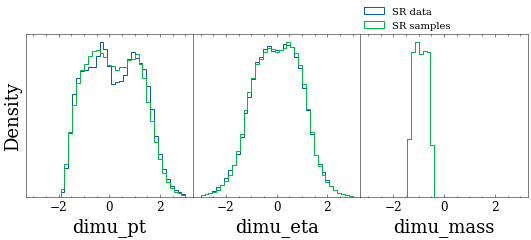

In [6]:

hist_all_features_array([data_dict["SR"], data_dict["SR_samples"]], ["SR data", "SR samples"], 
                        feature_set, plot_bound = 3, yscale_log = False)



## Train the BDTs

Train to discriminate (flow samples in SR) from (test data in SR)

In [52]:
import xgboost as xgb

# BDT HYPERPARAMETERS 

# best for feature set 3
n_estimators = 300 # number of boosting stages
max_depth = 5 # max depth of individual regression estimators; related to complexity
learning_rate = 0.1
subsample = 0.5 # fraction of samples to be used for fitting the individual base learners
early_stopping_rounds = 10 # stop training BDT is validation loss doesn't improve after this many rounds



In [53]:
def run_BDT_bump_hunt(flow_samples_SR, data_samples_SR, data_samples_SB, num_folds, num_to_ensemble, 
                      alt_test_sets_data={}, visualize=True):
    
    """
    Classifier is trained only on SR data, to distinguish flow SR samples from SR data
    
    Classifier is evaluated on test data from SR AND SB
    
    Note that alt test sets are NOT split into folds, since we aren't training on them. We do get diff scores for each fold
    """
    
    test_data_splits  = {i:0 for i in range(num_folds)}
    scores_splits = {i:0 for i in range(num_folds)}
    
    # split the alternative test sets
    alt_scores_splits = {}
    alt_data_splits = {}
    for alt_id in alt_test_sets_data.keys():
        alt_scores_splits[alt_id] = {i:0 for i in range(num_folds)}
        # generate a nfold split for the alt test data
        loc_alt_data_split = np.array_split(shuffle(alt_test_sets_data[alt_id]), num_folds) 
        alt_data_splits[alt_id] = {i:loc_alt_data_split[i] for i in range(num_folds)}
        
    # shuffle anything with SB data to mix the low and high masses before splitting 
    flow_samples_SR = shuffle(flow_samples_SR)
    data_samples_SR = shuffle(data_samples_SR)
    data_samples_SB = shuffle(data_samples_SB)
    
    flow_SR_splits = np.array_split(flow_samples_SR, num_folds)
    data_SR_splits = np.array_split(data_samples_SR, num_folds)
    data_SB_splits = np.array_split(data_samples_SB, num_folds) 
    
    for i_fold in range(num_folds):
            
        print(f"Fold {i_fold}:")
        
        """
        ASSEMBLE THE TRAIN / VAL / TEST DATA
        """
        
        # Assemble the train / test data
        training_data, training_labels = [], []
        validation_data, validation_labels = [], []
        testing_data = []

        for ii in range(num_folds):
            
            # test set comprised of SR and SB data
            if ii == i_fold:
                testing_data.append(data_SR_splits[ii])
                testing_data.append(data_SB_splits[ii])
                
            # validation set: flow SR samples, data SR sampkes
            elif ((ii+1)%num_folds) == i_fold:
                validation_data.append(flow_SR_splits[ii])
                validation_labels.append(np.zeros((flow_SR_splits[ii].shape[0],1)))
                validation_data.append(data_SR_splits[ii])
                validation_labels.append(np.ones((data_SR_splits[ii].shape[0],1)))
                
            else:
                training_data.append(flow_SR_splits[ii])
                training_labels.append(np.zeros((flow_SR_splits[ii].shape[0],1)))
                training_data.append(data_SR_splits[ii])
                training_labels.append(np.ones((data_SR_splits[ii].shape[0],1)))
                
        X_train_fold = np.concatenate(training_data)
        Y_train_fold = np.concatenate(training_labels)
        X_val_fold = np.concatenate(validation_data)
        Y_val_fold = np.concatenate(validation_labels)
        
        X_test_fold = np.concatenate(testing_data)
        
        # record the local fold data
        test_data_splits[i_fold] = X_test_fold
     
        """
        SORT THE WEIGHTS OUT
        """
        
        # First do the weights for the regular BC (non-decorr)
        class_weight = {0: 1, 1: sum(Y_train_fold==0)[0]/sum(Y_train_fold==1)[0]}
        class_weights_train = class_weight[0]*(1.0-Y_train_fold)+class_weight[1]*Y_train_fold
        class_weights_val = class_weight[0]*(1.0-Y_val_fold)+class_weight[1]*Y_val_fold
        
        """
        COMBINE W/ DECORRELATED TRAINING
        """
        # we only want to train on the non-mass features

        X_train_fold = X_train_fold[:,:-1]
        X_val_fold = X_val_fold[:,:-1]

        w_train_fold = class_weights_train
        w_val_fold = class_weights_val

        # shuffle for good measure
        X_train_fold, Y_train_fold, w_train_fold = shuffle(X_train_fold, Y_train_fold, w_train_fold)
        X_val_fold, Y_val_fold, w_val_fold = shuffle(X_val_fold, Y_val_fold, w_val_fold)
        
        X_test_fold = X_test_fold[:,:-1]
        
        
        print(f"X train shape: {X_train_fold.shape}, Y train shape: {Y_train_fold.shape}, w train shape: {w_train_fold.shape}.")
        print(f"X val shape: {X_val_fold.shape}, Y val shape: {Y_val_fold.shape}, w val shape: {w_val_fold.shape}.")
        print(f"X test shape: {X_test_fold.shape}." )
        
        """
        INITIALIZE SCORE OBJECTS
        """
        
        scores_fold = np.empty((X_test_fold.shape[0], num_to_ensemble))
        alt_scores_fold = {}
        for alt_id in alt_test_sets_data.keys():
            alt_scores_fold[alt_id] = np.empty((alt_data_splits[alt_id][i_fold].shape[0], num_to_ensemble))
            
   
        """
        TRAIN ENSEMBLE OF TREES
        """
    
        if visualize:
            plt.figure()
        
        for i_tree in range(num_to_ensemble):
            
            print("   Network number:", i_tree)
            random_seed = i_fold*num_to_ensemble + i_tree + 1
                
                
            eval_set = [(X_train_fold, Y_train_fold), (X_val_fold, Y_val_fold)]

            bst_i = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, 
                              subsample=subsample,  early_stopping_rounds=early_stopping_rounds,
                              objective='binary:logistic', 
                                      random_state = random_seed, eval_metric="logloss")

            bst_i.fit(X_train_fold, Y_train_fold, sample_weight=w_train_fold, 
                      eval_set=eval_set, sample_weight_eval_set = [w_train_fold, w_val_fold],
                      verbose=False)
            results_f = bst_i.evals_result()
            losses = results_f["validation_0"]["logloss"]
            losses_val = results_f["validation_1"]["logloss"]
            best_epoch = bst_i.best_iteration


            # get scores
            scores_fold[:,i_tree] = bst_i.predict_proba(X_test_fold, iteration_range=(0,bst_i.best_iteration))[:,1]
            for alt_id in alt_test_sets_data.keys():
                alt_scores_fold[alt_id][:,i_tree] = bst_i.predict_proba(alt_data_splits[alt_id][i_fold][:,:-1], iteration_range=(0,bst_i.best_iteration))[:,1]


            
            if visualize:
                
                plt.plot(losses, label = f"{i_tree}", color = f"C{i_tree}")
                plt.plot(losses_val, color = f"C{i_tree}", linestyle = "dashed")
                plt.xlabel("Epochs")
                plt.ylabel("Loss")
                plt.axvline(best_epoch, color = f"C{i_tree}")
                plt.title(f"Fold {i_fold}")
        
        if visualize:
            plt.legend()
            plt.show()
        
            
            
        """
        AVERAGE OVER ENSEMBLE
        """
        
        
            
        scores_splits[i_fold] = np.mean(scores_fold, axis = 1)
        for alt_id in alt_test_sets_data.keys():
            alt_scores_splits[alt_id][i_fold] = np.mean(alt_scores_fold[alt_id], axis = 1)
            
        plt.figure()
        plt.hist2d(test_data_splits[i_fold][:,-1], scores_splits[i_fold], bins = 40, cmap = "hot", density = True)
        plt.xlabel("M (rescaled)")
        plt.ylabel("score")
        #plt.axvline(SR_min_rescaled, color = "red")
        #plt.axvline(SR_max_rescaled, color = "red")
        plt.colorbar()
        plt.colorbar()
        plt.show()
        
        plt.figure()
        plt.hist2d(alt_data_splits["FPR_validation"][i_fold][:,-1], alt_scores_splits["FPR_validation"][i_fold], bins = 40, cmap = "hot", density = True)
        plt.xlabel("M (rescaled)")
        plt.ylabel("score")
        plt.axvline(SR_min_rescaled, color = "red")
        plt.axvline(SR_max_rescaled, color = "red")
        plt.title("FPR_validation")
        plt.colorbar()
        plt.show()
        
        plt.figure()
        plt.hist2d(alt_data_splits["samesign"][i_fold][:,-1], alt_scores_splits["samesign"][i_fold], bins = 40, cmap = "hot", density = True)
        plt.xlabel("M (rescaled)")
        plt.ylabel("score")
        #plt.axvline(SR_min_rescaled, color = "red")
        #plt.axvline(SR_max_rescaled, color = "red")
        plt.title("samesign")
        plt.colorbar()
        plt.show()
        print()
        
    return test_data_splits, scores_splits, alt_data_splits, alt_scores_splits




In [ ]:
# Train a classifier to discriminate SR samples from SR data

n_folds = 5
n_to_ensemble = 25

alt_test_sets_data = {"FPR_validation":data_dict["SR_samples_validation"],
                      "samesign":test_events_samesign,
                      "ROC":test_events_ROC}

test_events_ROC

test_data_splits, scores_splits, alt_data_splits, alt_scores_splits = run_BDT_bump_hunt(clean_data(data_dict["SR_samples"]), 
                                        clean_data(test_events_SR), clean_data(test_events_SB), n_folds, n_to_ensemble, 
                                            alt_test_sets_data=alt_test_sets_data,
                                                                     visualize=True)



Fold 0:
X train shape: (64313, 2), Y train shape: (64313, 1), w train shape: (64313, 1).
X val shape: (21437, 2), Y val shape: (21437, 1), w val shape: (21437, 1).
X test shape: (7000, 2).
   Network number: 0
   Network number: 1
   Network number: 2
   Network number: 3
   Network number: 4


## Analysis


### True bump hunt

- Define a polynomial form for the background fit
- For each cut on the classifier score:
  - Fit the background on the cut SB data
  - Estimate N_bkg
  - Calculate S/B, S/sqrt(B)



In [ ]:
with open(f"{working_dir}/processed_data/mass_scaler_{particle_type}", "rb") as ifile:
    scaler = pickle.load(ifile)
    
fpr_thresholds = [1, 0.25, 0.1, 0.05, 0.01]
score_cutoffs = {i:[] for i in range(n_folds)}


for i_fold in range(n_folds):
    for t in fpr_thresholds:
        
        loc_scores_sorted = np.sort(1.0-alt_scores_splits["FPR_validation"][i_fold])
        score_cutoff = 1-loc_scores_sorted[min(int(t*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
        score_cutoffs[i_fold].append(score_cutoff)  


In [ ]:
SB_left = float(workflow[particle_type]["SB_left"])
SR_left = float(workflow[particle_type]["SR_left"])
SR_right = float(workflow[particle_type]["SR_right"])
SB_right = float(workflow[particle_type]["SB_right"])
    
TPRs, FPRs = [], []

remove_edge = True


    
    
x = np.linspace(SB_left, SB_right, 100)

# get bins, bin centers
plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, remove_edge)


fit_type = "cubic"
if fit_type == "cubic": fit_function = bkg_fit_cubic
elif fit_type == "quintic": fit_function = bkg_fit_quintic
elif fit_type == "ratio": fit_function = bkg_fit_ratio


plt.figure(figsize = (12, 9))
for t, threshold in enumerate(fpr_thresholds):
    
    # corrections to SR / SB efficiencies
    filtered_masses = []
    
    for i_fold in range(n_folds):
        
        
        loc_true_masses = scaler.inverse_transform(np.array(test_data_splits[i_fold][:,-1]).reshape(-1,1))
        loc_filtered_masses, loc_SBL_eff, loc_SBH_eff, loc_SR_eff = select_top_events_fold(loc_true_masses, scores_splits[i_fold], score_cutoffs[i_fold][t],
                                                                                           plot_bins_left, plot_bins_right, plot_bins_SR)
        

        filtered_masses.append(loc_filtered_masses)

        

    filtered_masses = np.concatenate(filtered_masses)

    
    # get the fit function to SB background
    popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_all,)
    #print("chi2/dof:", chi2/n_dof)
    # plot the fit function
    plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    
    
    # calculate significance of bump
    num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, SR_left, SR_right, popt)
    
    if threshold == 1:
        S_total, B_total = num_S_expected_in_SR, num_B_expected_in_SR
    
    TPRs.append(num_S_expected_in_SR/S_total)
    FPRs.append(num_B_expected_in_SR/B_total)
        

    y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
    B_error = np.sum(y_err)

    label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(num_S_expected_in_SR/num_B_expected_in_SR,2))+", $S/\sqrt{B}$: "+str(round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2),2))

    plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string)
    plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")
    
    

print() 
plt.legend(loc = (1, 0), fontsize = 24)


plt.axvline(SR_left, color= "k", lw = 3, zorder = -10)
plt.axvline(SR_right, color= "k", lw = 3, zorder = -10)

plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 24)
plt.ylabel("Counts", fontsize = 24)
plt.title(f"{particle_type}\n"+"  ".join(feature_set[:-1])+"\n", fontsize = 24)
plt.show()






Repeat for samesign background

In [ ]:
fit_type = "cubic"
if fit_type == "cubic": fit_function = bkg_fit_cubic
elif fit_type == "quintic": fit_function = bkg_fit_quintic
elif fit_type == "ratio": fit_function = bkg_fit_ratio



plt.figure(figsize = (12, 9))
for t, threshold in enumerate(fpr_thresholds):
    
    # corrections to SR / SB efficiencies
    filtered_masses = []
    
    for i_fold in range(n_folds):
        
        loc_true_masses = scaler.inverse_transform(alt_data_splits["samesign"][i_fold][:,-1].reshape(-1,1))
        loc_filtered_masses, loc_SBL_eff, loc_SBH_eff, loc_SR_eff = select_top_events_fold(loc_true_masses, alt_scores_splits["samesign"][i_fold], score_cutoffs[i_fold][t],
                                                                                           plot_bins_left, plot_bins_right, plot_bins_SR)
        
        filtered_masses.append(loc_filtered_masses)

        
    filtered_masses = np.concatenate(filtered_masses)

    
    # get the fit function to SB background
    popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_all)
    #print("chi2/dof:", chi2/n_dof)
    # plot the fit function
    plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    
    
    # calculate significance of bump
    num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, SR_left, SR_right, popt)
    #print(num_S_expected_in_SR, num_B_expected_in_SR)

    y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
    B_error = np.sum(y_err)

    label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(num_S_expected_in_SR/num_B_expected_in_SR,2))+", $S/\sqrt{B}$: "+str(round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2),2))

    plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string)
    plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")
    
    
    
    
#plt.title(",  ".join(feature_set[:-1])+"\n", fontsize = 18) 
plt.legend(loc = (1, 0), fontsize = 24)
#plt.yscale("log")

plt.axvline(SR_left, color= "k", lw = 3, zorder = -10)
plt.axvline(SR_right, color= "k", lw = 3, zorder = -10)

plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 24)
plt.ylabel("Counts", fontsize = 24)
plt.title(f"{particle_type} same sign", fontsize = 24)

plt.show()

In [ ]:
SB_left = float(workflow[particle_type]["SB_left"])
SR_left = float(workflow[particle_type]["SR_left"])
SR_right = float(workflow[particle_type]["SR_right"])
SB_right = float(workflow[particle_type]["SB_right"])
    
TPRs, FPRs = [], []

remove_edge = True


    
    
x = np.linspace(SB_left, SB_right, 100)

# get bins, bin centers
plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, remove_edge)


fit_type = "cubic"
if fit_type == "cubic": fit_function = bkg_fit_cubic
elif fit_type == "quintic": fit_function = bkg_fit_quintic
elif fit_type == "ratio": fit_function = bkg_fit_ratio


plt.figure(figsize = (12, 9))
for t, threshold in enumerate(fpr_thresholds):
    
    # corrections to SR / SB efficiencies
    filtered_masses = []
    
    for i_fold in range(n_folds):
        
        
        loc_true_masses = scaler.inverse_transform(np.array(alt_data_splits["ROC"][i_fold][:,-1]).reshape(-1,1))
        loc_filtered_masses, loc_SBL_eff, loc_SBH_eff, loc_SR_eff = select_top_events_fold(loc_true_masses, alt_scores_splits["ROC"][i_fold], score_cutoffs[i_fold][t],
                                                                                           plot_bins_left, plot_bins_right, plot_bins_SR)
        

        filtered_masses.append(loc_filtered_masses)

        

    filtered_masses = np.concatenate(filtered_masses)

    
    # get the fit function to SB background
    popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_all,)
    #print("chi2/dof:", chi2/n_dof)
    # plot the fit function
    plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    
    
    # calculate significance of bump
    num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, SR_left, SR_right, popt)
    
    if threshold == 1:
        S_total, B_total = num_S_expected_in_SR, num_B_expected_in_SR
    
    TPRs.append(num_S_expected_in_SR/S_total)
    FPRs.append(num_B_expected_in_SR/B_total)
        

    y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
    B_error = np.sum(y_err)

    label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(num_S_expected_in_SR/num_B_expected_in_SR,2))+", $S/\sqrt{B}$: "+str(round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2),2))

    plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string)
    plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")
    
    

print() 
plt.legend(loc = (1, 0), fontsize = 24)


plt.axvline(SR_left, color= "k", lw = 3, zorder = -10)
plt.axvline(SR_right, color= "k", lw = 3, zorder = -10)

plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 24)
plt.ylabel("Counts", fontsize = 24)
plt.title(f"{particle_type}\n"+"  ".join(feature_set[:-1])+"\n", fontsize = 24)
plt.show()


ROC curve


In [ ]:

    
TPRs, FPRs = [], []

remove_edge = True



fit_type = "cubic"
if fit_type == "cubic": fit_function = bkg_fit_cubic
elif fit_type == "quintic": fit_function = bkg_fit_quintic
elif fit_type == "ratio": fit_function = bkg_fit_ratio



fpr_thresholds = np.linspace(1, 0, 50)


for t, threshold in enumerate(fpr_thresholds):
    
    # corrections to SR / SB efficiencies
    filtered_masses = []
    
    for i_fold in range(n_folds):
        
        loc_scores_sorted = np.sort(1.0-alt_scores_splits["FPR_validation"][i_fold])
        score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
        
        
        # oppsign
        loc_true_masses = scaler.inverse_transform(np.array(alt_data_splits["ROC"][i_fold][:,-1]).reshape(-1,1))
        loc_filtered_masses, loc_SBL_eff, loc_SBH_eff, loc_SR_eff = select_top_events_fold(loc_true_masses, alt_scores_splits["ROC"][i_fold], score_cutoff,
                                                                                          plot_bins_left, plot_bins_right, plot_bins_SR)
        
        # samesign
        #loc_true_masses = scaler.inverse_transform(test_events_samesign[:,-1].reshape(-1,1))
        #loc_filtered_masses, loc_SBL_eff, loc_SBH_eff, loc_SR_eff = select_top_events_fold(loc_true_masses, alt_scores_splits["samesign"][i_fold], score_cutoff,
         #                                                                                  plot_bins_left, plot_bins_right, plot_bins_SR)
        

        filtered_masses.append(loc_filtered_masses)

    filtered_masses = np.concatenate(filtered_masses)

    # get the fit function to SB background
    popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_all,)

    num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, SR_left, SR_right, popt)
    
    if threshold == 1:
        S_total, B_total = num_S_expected_in_SR, num_B_expected_in_SR
    
    TPRs.append(num_S_expected_in_SR/S_total)
    FPRs.append(num_B_expected_in_SR/B_total)
        
TPRs = np.array(TPRs)
FPRs = np.array(FPRs)



In [ ]:
plt.figure()
plt.plot(FPRs, TPRs)
plt.plot(FPRs, FPRs, linestyle = "dashed", color = "grey")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()


plt.figure()
plt.plot(TPRs, 1.0/FPRs)
plt.plot(TPRs, 1.0/TPRs, linestyle = "dashed", color = "grey")
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.yscale("log")
plt.show()

    
plt.figure()
plt.plot(TPRs, TPRs/np.sqrt(FPRs))
plt.plot(TPRs, TPRs/np.sqrt(TPRs), linestyle = "dashed", color = "grey")
plt.xlabel("tpr")
plt.ylabel("SIC")
plt.show()